# Statistical Algorithm: using fbprophet for Crypto Data Time Series Forecast 

Junfan Zhu

---
fbprophet package can be found on https://github.com/facebook/prophet/tree/master/notebooks 

# Data Explanation and Drawbacks of the package

Drawback of this package: fbprophet assumes the type of time series is one data point per day. This causes incompatibility of the model package, and the issue of timestamp remains to be optimized in future in our time series analysis.
***

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally ```YYYY-MM-DD``` for a date or ```YYYY-MM-DD HH:MM:SS``` for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.
***
However, I have problem in changing the timestamp format, there is timezone information in the timestamp. It turns out error like this:
***
__ValueError: Column ds has timezone specified, which is not supported. Remove timezone.__

I used 'spread.csv' data, only chosing 2 columns: 'spread' and the timestamp, each has 1000 rows of data. 
***
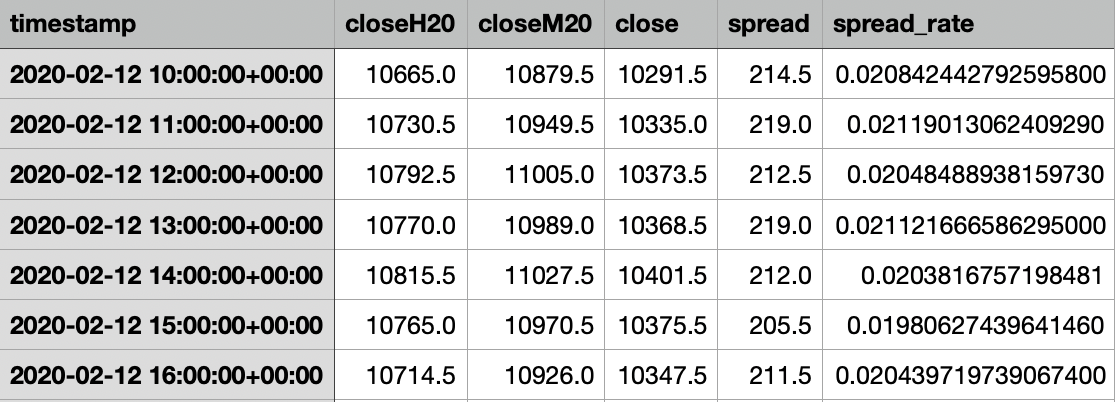

But I found that fbprophet isn't accustomed to __one day dozens of data__ style, as this model only assumes __one data in one day__. For analysis purpose, I changed each timestamp to an increasing list of virtual days. 
***
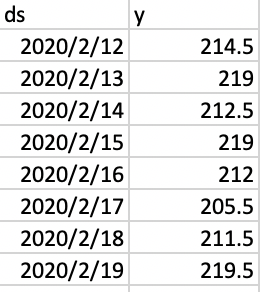
Although the real meaning of 'date' is false, as I changed from an hourly-basis to a daily-basis, but somehow we can view this as a new time series and conduct analysis on the data of 'spread' only. We can also map the 'false date' in the model to the real timestamp in our original data, using the spread column.

In [1]:
!pip install fbprophet
from fbprophet import Prophet
import pandas as pd
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/Users/junfanzhu/Desktop/spreadscopy.csv')
df

,ds,y
0,2020/2/12,214.5
1,2020/2/13,219.0
2,2020/2/14,212.5
3,2020/2/15,219.0
4,2020/2/16,212.0
...,...,...
995,2022/11/3,-20.0
996,2022/11/4,-33.5
997,2022/11/5,-17.0
998,2022/11/6,-19.0


# Fit the model

In [3]:
m = Prophet()
m.fit(df)
m

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Make Predictions. Dataframe extends into the future

In [4]:
future = m.make_future_dataframe(periods=365)
future

,ds
0,2020-02-12
1,2020-02-13
2,2020-02-14
3,2020-02-15
4,2020-02-16
...,...
1360,2023-11-03
1361,2023-11-04
1362,2023-11-05
1363,2023-11-06


# Forecast. Forecast will include an uncertainty interval

In [5]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1360,2023-11-03,-152.248368,-261.369097,-46.483839
1361,2023-11-04,-153.222283,-267.121835,-45.951069
1362,2023-11-05,-150.554875,-267.310703,-41.745024
1363,2023-11-06,-151.482359,-271.121427,-44.923339
1364,2023-11-07,-149.725717,-265.523044,-46.936435


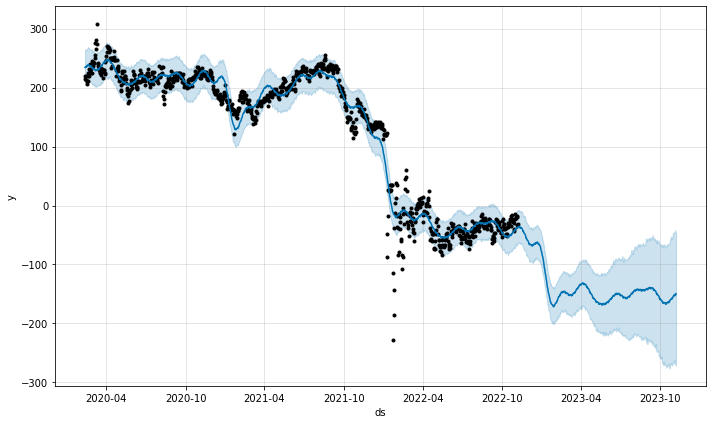

In [6]:
fig1 = m.plot(forecast)

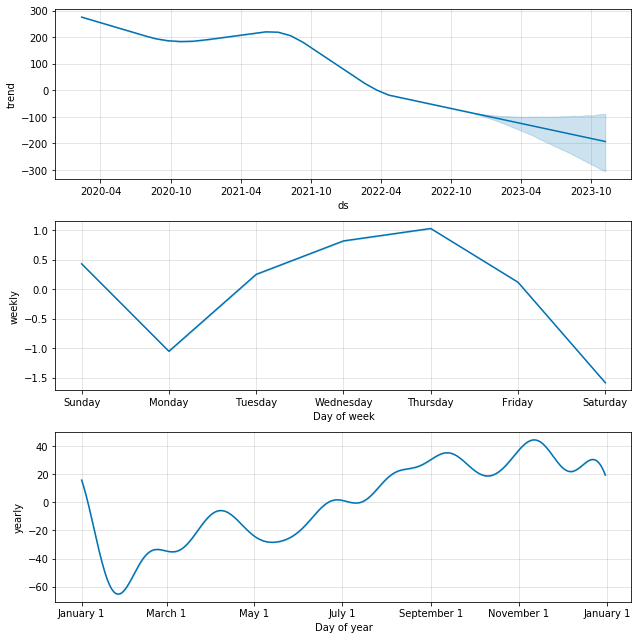

In [7]:
fig2 = m.plot_components(forecast)

In [8]:
!pip install plotly

# Automatic Change Point Detection

Real time series frequently have abrupt changes in their trajectories. By default, Prophet automatically detects these changepoints and will allow the trend to adapt appropriately. 
***
Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization). By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed:

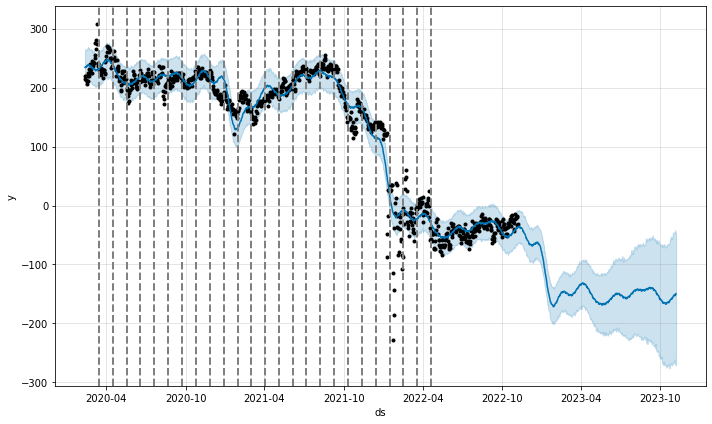

In [9]:
fig = m.plot(forecast)
for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)

Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused. We can see this by plotting the magnitude of the rate change at each changepoint:

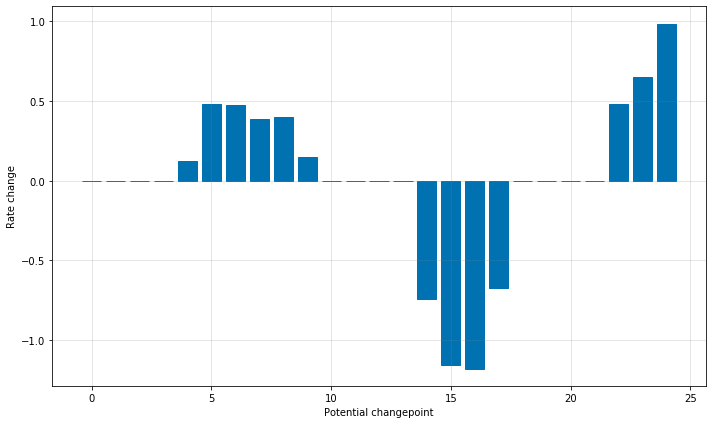

In [10]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

The number of potential changepoints can be set using the argument n_changepoints, but this is better tuned by adjusting the regularization. The locations of the signification changepoints can be visualized with:

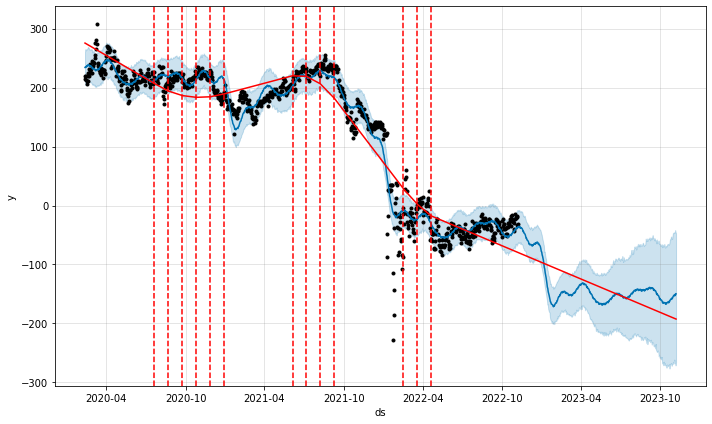

In [11]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be change using the changepoint_range argument. For example, ```m = Prophet(changepoint_range=0.9)``` will place potential changepoints in the first 90% of the time series.

# Adjusting trend flexibility 

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument ```changepoint_prior_scale```. By default, this parameter is set to 0.05. Increasing it will make the trend __*more*__ flexible:

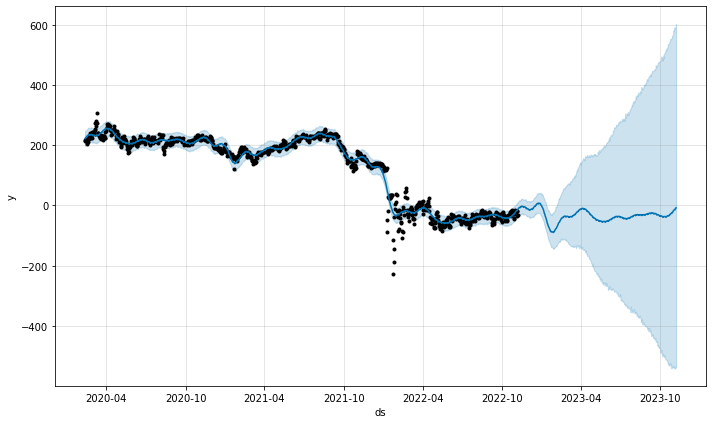

In [12]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

Decreasing it will make the trend __*less*__ flexible:

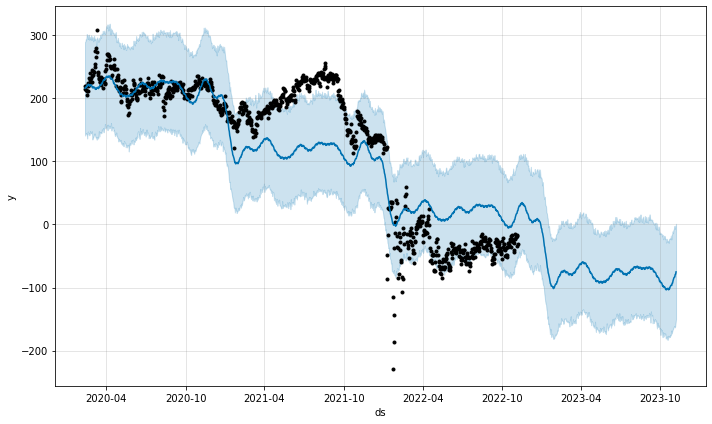

In [13]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

# Specifying the locations of the changepoints

Manually specify the locations of potential changepoints with the changepoints argument. 
***
Slope changes will then be allowed only at these points, with the same sparse regularization as before. We can create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. The changepoints could be entirely limited to a small set of dates, as is done here:

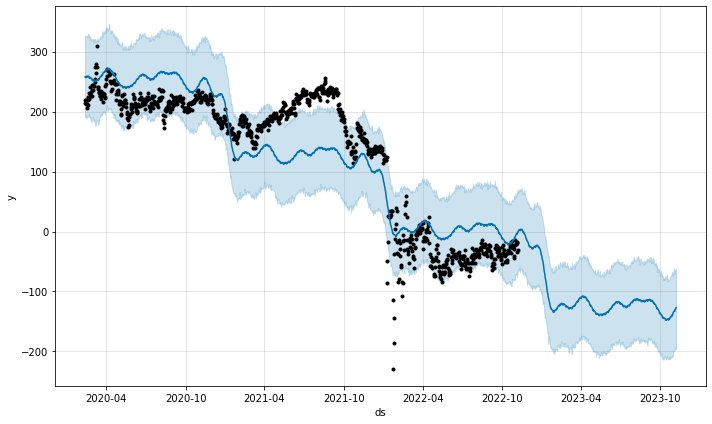

In [14]:
m = Prophet(changepoints=['2020-03-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

# Modeling the Trend effect

The biggest source of uncertainty in the forecast is the potential for future trend changes. The time series we have seen already in this documentation show clear trend changes in the history. We assume that the average frequency and magnitude of trend changes in the future will be the same as that which we observe in the history. We project these trend changes forward and by computing their distribution we obtain uncertainty intervals.
***
One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing changepoint_prior_scale, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting.
***
The width of the uncertainty intervals (by default 80%) can be set using the parameter interval_width:

In [15]:
forecast_new = Prophet(interval_width=0.95).fit(df).predict(future)
forecast_new

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-12,275.553034,191.359940,275.331806,275.553034,275.553034,-41.466301,-41.466301,-41.466301,0.817957,0.817957,0.817957,-42.284258,-42.284258,-42.284258,0.0,0.0,0.0,234.086733
1,2020-02-13,275.123610,193.378789,281.502099,275.123610,275.123610,-39.712894,-39.712894,-39.712894,1.028623,1.028623,1.028623,-40.741517,-40.741517,-40.741517,0.0,0.0,0.0,235.410716
2,2020-02-14,274.694186,193.547349,281.925635,274.694186,274.694186,-39.219182,-39.219182,-39.219182,0.116620,0.116620,0.116620,-39.335802,-39.335802,-39.335802,0.0,0.0,0.0,235.475004
3,2020-02-15,274.264762,190.901446,276.546890,274.264762,274.264762,-39.666151,-39.666151,-39.666151,-1.587838,-1.587838,-1.587838,-38.078314,-38.078314,-38.078314,0.0,0.0,0.0,234.598610
4,2020-02-16,273.835338,193.173303,281.656251,273.835338,273.835338,-36.547152,-36.547152,-36.547152,0.429423,0.429423,0.429423,-36.976575,-36.976575,-36.976575,0.0,0.0,0.0,237.288185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,2023-11-03,-191.329210,-337.889387,18.957850,-370.271935,-31.618297,39.080842,39.080842,39.080842,0.116620,0.116620,0.116620,38.964222,38.964222,38.964222,0.0,0.0,0.0,-152.248368
1361,2023-11-04,-191.638879,-335.652507,11.763975,-371.403671,-31.152095,38.416596,38.416596,38.416596,-1.587838,-1.587838,-1.587838,40.004434,40.004434,40.004434,0.0,0.0,0.0,-153.222283
1362,2023-11-05,-191.948548,-335.439230,15.547051,-372.535407,-30.829139,41.393674,41.393674,41.393674,0.429423,0.429423,0.429423,40.964251,40.964251,40.964251,0.0,0.0,0.0,-150.554875
1363,2023-11-06,-192.258218,-334.335050,18.575366,-373.667143,-30.526224,40.775859,40.775859,40.775859,-1.054992,-1.054992,-1.054992,41.830851,41.830851,41.830851,0.0,0.0,0.0,-151.482359


# Modeling the Seasonality Effect

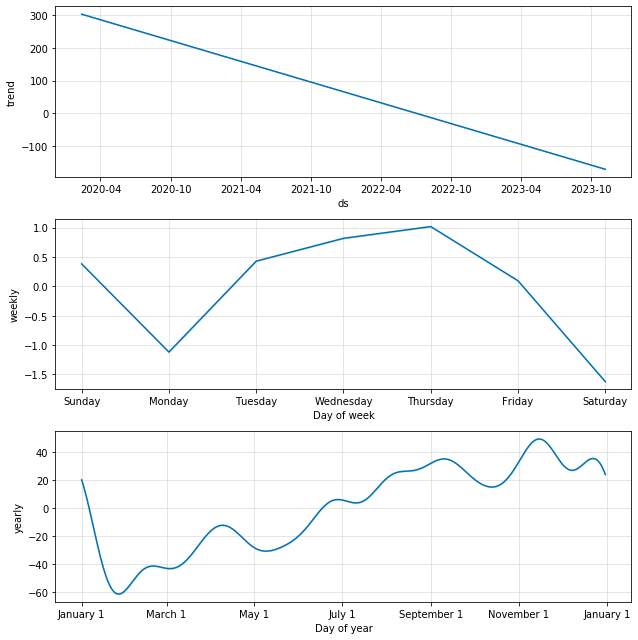

In [16]:
fig = m.plot_components(forecast)

# Fourier Order for Seasonalities¶

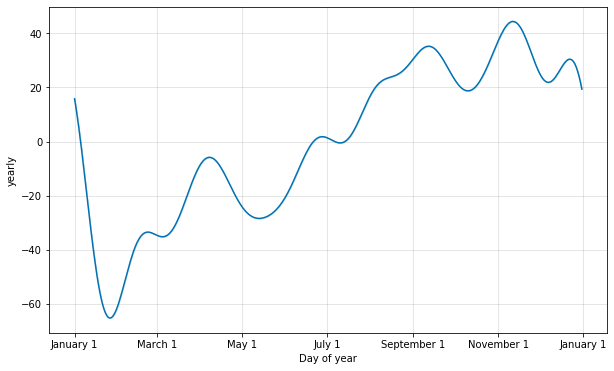

In [17]:
from fbprophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here it is increased to 20:

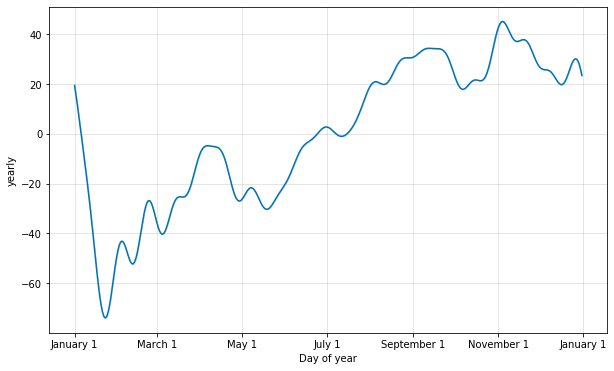

In [18]:
from fbprophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle

# Sub-daily data¶

Prophet can make forecasts for time series with sub-daily observations by passing in a dataframe with timestamps in the ```ds``` column. The format of the timestamps should be ```YYYY-MM-DD HH:MM:SS```. When sub-daily data are used, daily seasonality will automatically be fit.

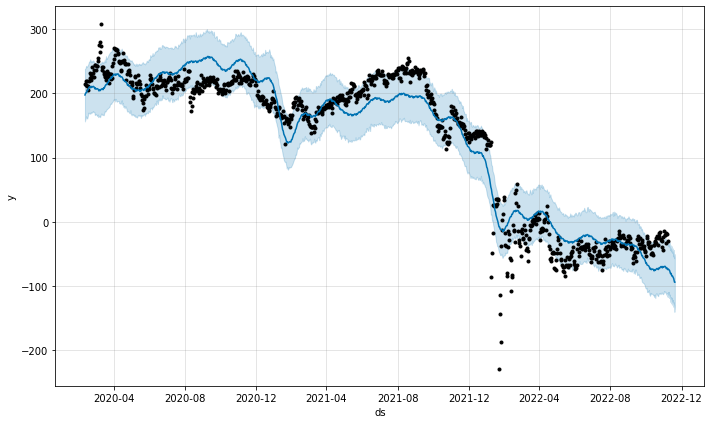

In [19]:
df_new = pd.read_csv('/Users/junfanzhu/Desktop/spreadscopy.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df_new)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

# Daily seasonality

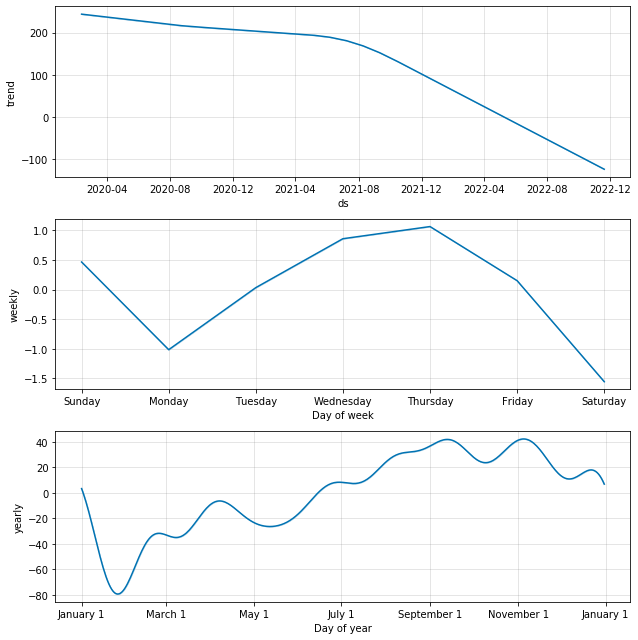

In [20]:
fig = m.plot_components(fcst)

# Data with regular gaps

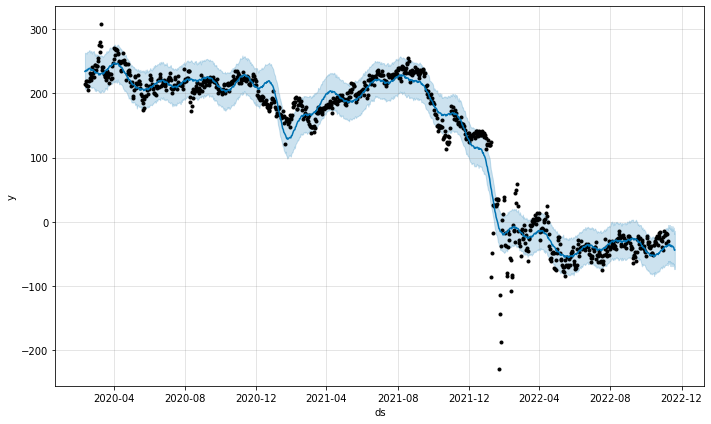

In [21]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

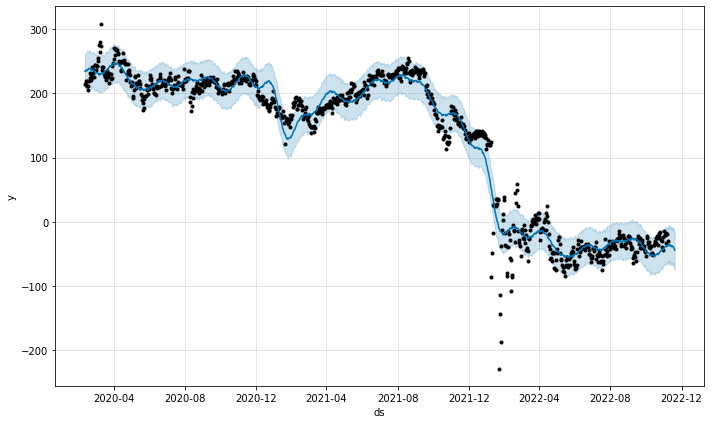

In [22]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

# Saturating Forecasts

The logistic growth model can also handle a saturating minimum, which is specified with a column floor in the same way as the cap column specifies the maximum:

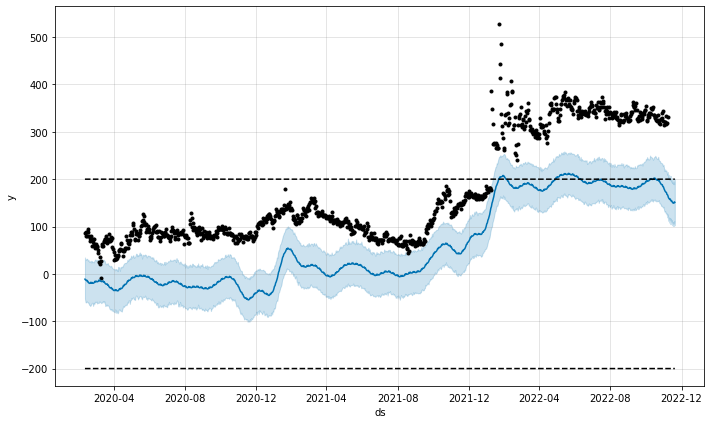

In [23]:
df['y'] = 300 - df['y']
df['cap'] = 300
df['floor'] = -100
future['cap'] = 200
future['floor'] = -200
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.